In [1]:
import numpy as np
from salient_data import *
import random

# Third party imports
import matplotlib.colors as colors_mat
import matplotlib.pyplot as plt
import numpy as np
import torch

# Sisal imports
from sisal.kernel_adapted import kernel_adapted_opt, plot_kernel_adapted
from sisal.plot import Plot
from sisal.solver import Solver
from sisal.utils import normalize_train_test_full_loader_given_index

## Dataset

- **Dataset name:** HyperSpectral Salient Object Detection Dataset (HS-SOD) 
- **DOI:** [10.1109/QoMEX.2018.8463428](https://doi.org/10.1109/QoMEX.2018.8463428)  
- **Github Link:** [View data on Github](https://github.com/gistairc/HS-SOD)

In [2]:
name ='0012'
data,index,image_shape = return_data_salient(name)
spectral_range_val = spectral_range()
index_to_image_map = index_to_image_pos()
nm_values = spectral_range()
# mask is not given in this dataset 
mask = np.zeros(data.shape[0])
target_ROI_arr = ["Unknwon"]
mask_to_name = zip(range(0, len(target_ROI_arr) + 1), target_ROI_arr)
mask_to_name = dict(mask_to_name)
train_loader, test_loader, full_index_loader = normalize_train_test_full_loader_given_index(data,index,mask)


Loading image 0012
Loading image 0012


In [3]:
beta = 4
z_dim = 2
in_size = data.shape[1]
epochs = 30
device = "cpu"
save_model_epochs = False
save_loss = False
train = True

In [4]:
model_filename = f"model_salient_beta_{beta}.pth"

In [5]:
# Set a fixed seed for reproducibility
seed = 5945
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Training SiSAL model

In [6]:
net = Solver(beta, z_dim, in_size, epochs, device, save_model_epochs, save_loss, train)

In [7]:
# The training will take some time.
# The training might finish before the maximum number of epochs if early stopping is triggered.
net.train(train_loader, test_loader, model_filename)

Training model:  30%|███       | 9/30 [12:38<29:29, 84.28s/epoch]


PosixPath('model_salient_beta_4.pth')

## Plot 

In [7]:
p = Plot(model_filename, device, train_loader, test_loader, full_index_loader)


Computing latent: 100%|██████████| 24576/24576 [00:16<00:00, 1518.70batch/s]


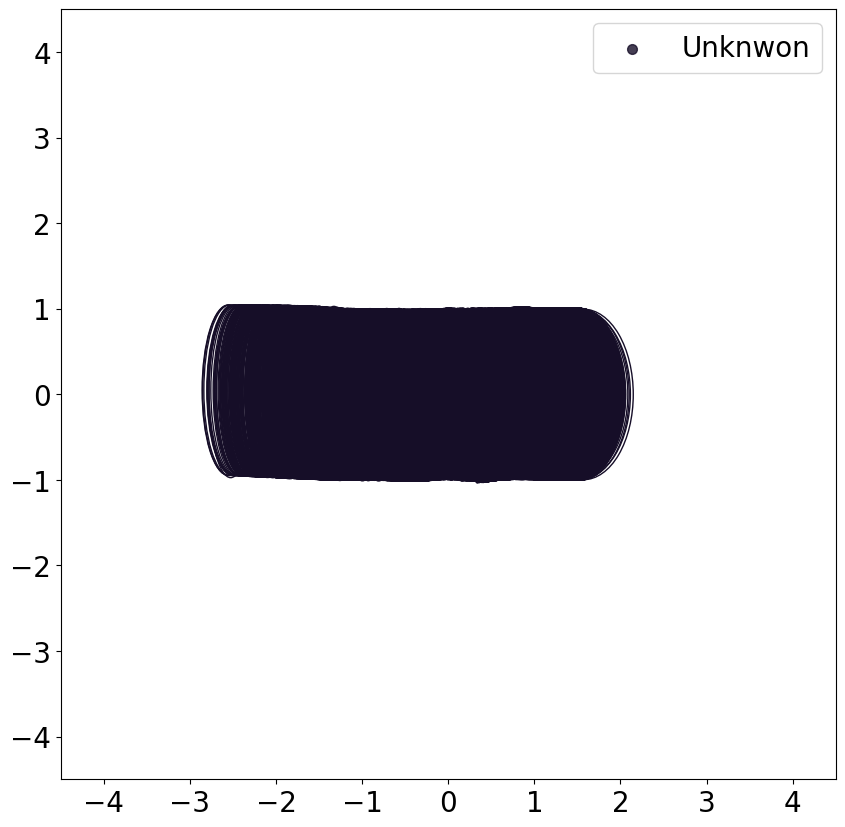

In [8]:
p.plot_latent_dim_with_var(mask_to_name, p=0.01)

## Kernel density estimation 

Text(0.5, -0.5, 'New Generated Masks')

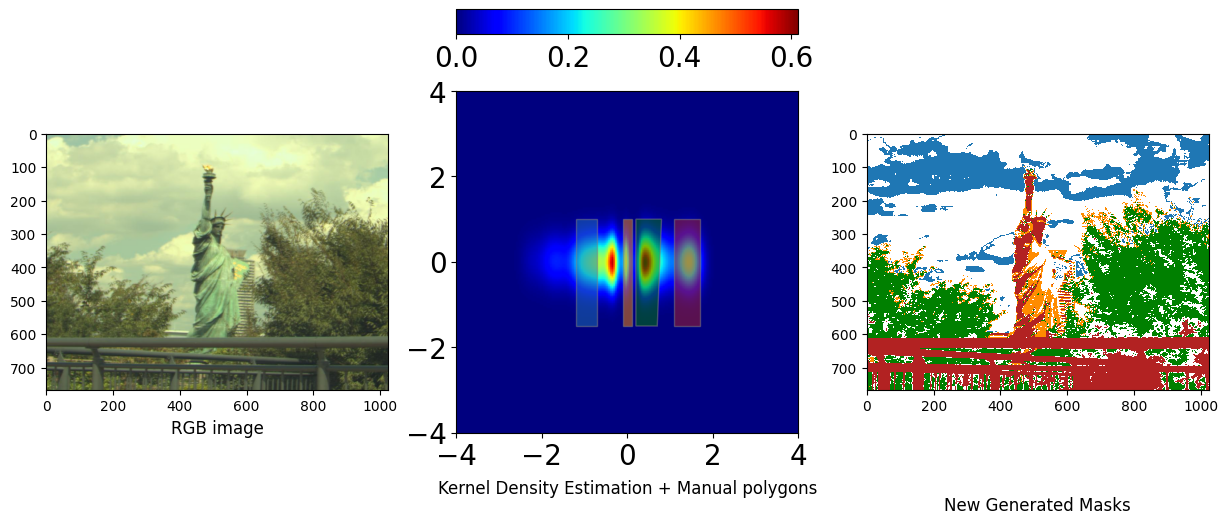

In [ ]:
# plot_carving_separate
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)

# Left Image (Original image)
im = return_rgb_image()
axs[0].imshow(im)
axs[0].set_title('RGB image', y=-0.2)


# Middle image (KDE)
axs[1].tick_params(axis="x", labelsize=20)
axs[1].tick_params(axis="y", labelsize=20)
axs[1].set_title("Kernel Density Estimation + Manual polygons", y=-0.2)
image = kernel_adapted_opt(p.full_latent, p.vars)
plot_kernel_adapted(axs[1], fig, image)

pol_limit1 = [(-1.2, -1.5), (-0.7, -1.5), (-0.7, 1), (-1.2, 1)]
pol_limit2 = [(-0.1, -1.5), (0.1, -1.5), (0.1, 1), (-0.1, 1)]  
pol_limit3 = [(0.2, -1.5), (0.7, -1.5), (0.8, 1), (0.2, 1)]  
pol_limit4 = [(1.1, -1.5), (1.7, -1.5), (1.7, 1), (1.1, 1)]
pol_limits = [pol_limit1, pol_limit2,pol_limit3,pol_limit4]
colors = ['#1f77b4', 'darkorange', 'green', 'firebrick', 'black', 'darkmagenta']    
colors = colors[:len(pol_limits)]
masks = p.plot_polygons_get_mask(axs[1], pol_limits, colors, index_to_image_map, image_shape)

# Right image (masks)
cmap_col = colors_mat.ListedColormap(["white", *colors])
axs[2].imshow(masks, cmap_col, interpolation="none")
axs[2].set_title("New Generated Masks", y=-0.2)

## Latent traversal subdivision

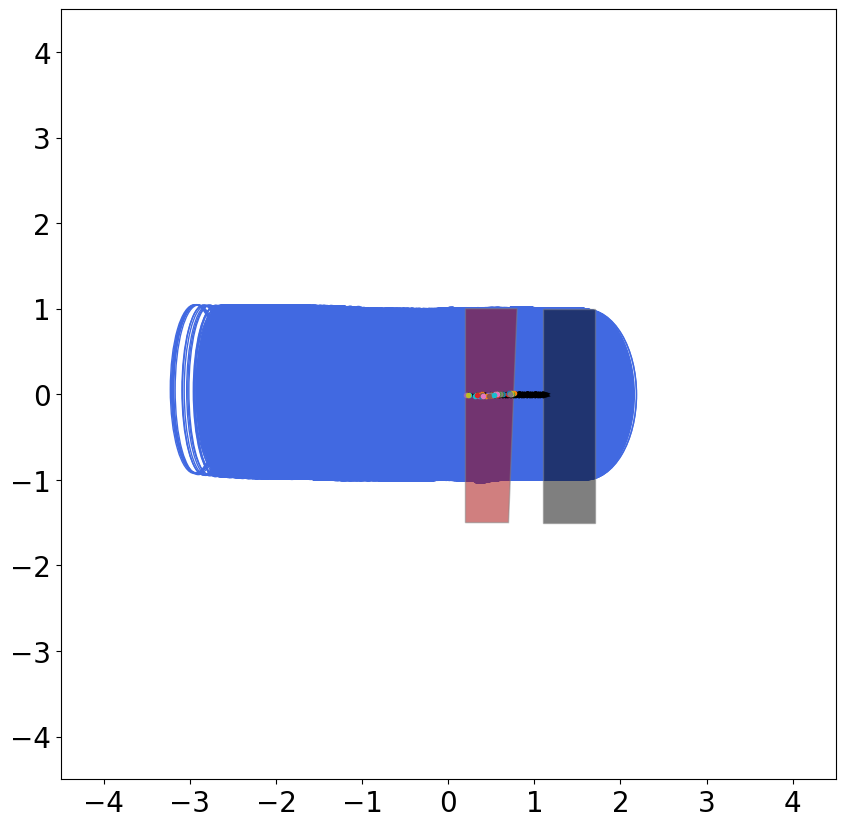

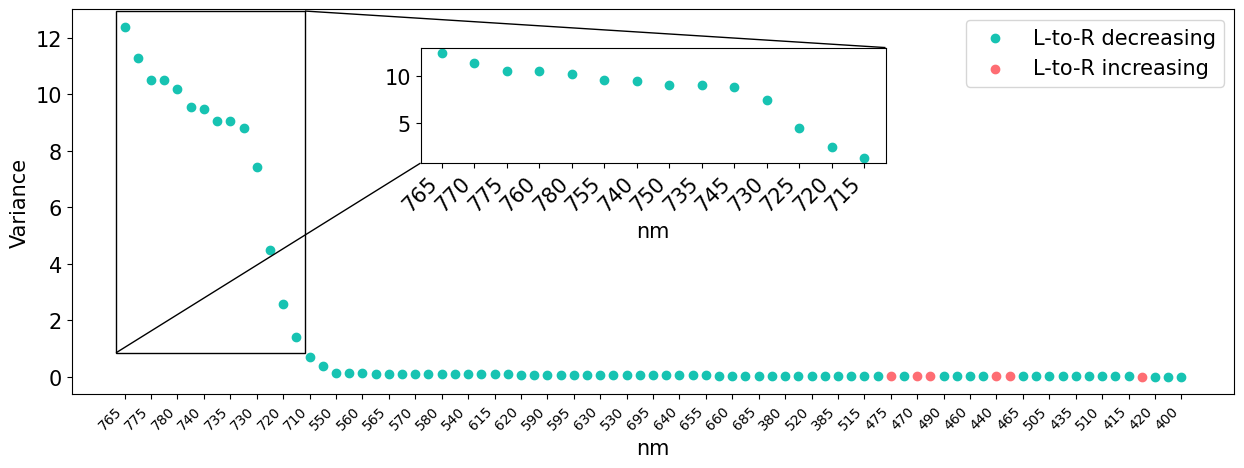

In [10]:
all_points = p.latent_traversal_legs(mask_to_name, pol_limits[2], pol_limits[3])
d = data.shape[1]
combined_p = p.get_reconstruction(all_points, d)
variance_latent_traversal_hyperspectral(combined_p, nm_values, d)